# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
import time

In [3]:
df_data = t.from_pkl(f'{processed_data_path}/df_clean.pkl')

df_data.shape
df_data.head(3)

(97053, 8)

,make,model,year,price,transmission,mileage,fuelType,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,1.4


In [4]:
df_data.insert(0, 'car', df_data['make'] + '__' + df_data['model'])
df_data = df_data.drop(columns=['make', 'model'])

In [5]:
df_data.groupby(['car']).size().sort_values(ascending=False).head(10)

car
Ford__Fiesta       6489
Vw__Golf           4766
Ford__Focus        4544
Merc__C Class      3689
Vauxhall__Corsa    3279
Vw__Polo           3230
Vauxhall__Astra    2641
Merc__A Class      2468
Bmw__3 Series      2409
Ford__Kuga         2207
dtype: int64

In [112]:
df_1_car = df_data.loc[ (df_data['car'] == 'Ford__Fiesta') ].drop(columns=['car']).copy()
df_1_car.head(3)

,year,price,transmission,mileage,fuelType,engineSize
21449,2017,12000,Automatic,15944,Petrol,1.0
21452,2019,17500,Manual,10460,Petrol,1.5
21453,2019,16500,Automatic,1482,Petrol,1.0


In [7]:
mileage_5k = ((df_1_car['mileage'] / 5000).round(0) * 5000).astype(int)
df_grp = df_1_car.drop(columns='mileage').groupby(['year', 'transmission', mileage_5k, 'fuelType', 'engineSize'])['price'].agg([len, np.mean, np.std, m.mad])

'mean group size: ', df_grp['len'].mean()
'price mad in 5k groups: ', df_grp['mad'].mean()
'price std in 5k groups: ', df_grp['std'].mean()

('mean group size: ', 10.655172413793103)

('price mad in 5k groups: ', 326.5094316074065)

('price std in 5k groups: ', 696.6597777424047)

In [8]:
mileage_10k = ((df_1_car['mileage'] / 10000).round(0) * 10000).astype(int)
df_grp = df_1_car.drop(columns='mileage').groupby(['year', 'transmission', mileage_10k, 'fuelType', 'engineSize'])['price'].agg([len, np.mean, np.std, m.mad])

'mean group size: ', df_grp['len'].mean()
'price mad in 5k groups: ', df_grp['mad'].mean()
'price std in 5k groups: ', df_grp['std'].mean()

('mean group size: ', 15.711864406779661)

('price mad in 5k groups: ', 344.2007726118433)

('price std in 5k groups: ', 722.0580288841817)

# Encode

In [113]:
df_1_car['age'] = (2022 - df_1_car['year'])
df_1_car['mileage_k'] = df_1_car['mileage']/ 1000
df_1_car['price_k'] = df_1_car['price']/ 1000

df_1_car.drop(columns=['year', 'mileage', 'price'], inplace=True)

m.ordinalEncode(df_1_car, ['transmission', 'fuelType'])
df_1_car.head(3)

,transmission,fuelType,engineSize,age,mileage_k,price_k
21449,0,1,1.0,5,15.944,12.0
21452,1,1,1.5,3,10.460,17.5
21453,0,1,1.0,3,1.482,16.5


# Train model

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import minmax_scale, normalize, scale, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_regression

## First Run

In [82]:
df_train = df_1_car
X, y  = df_train.drop(columns='price_k').copy(), df_train['price_k'].copy()

y.shape
X.shape
X.columns
X.head(3)
y.head(3)

(6489,)

(6489, 5)

Index(['transmission', 'fuelType', 'engineSize', 'age', 'mileage_k'], dtype='object')

,transmission,fuelType,engineSize,age,mileage_k
21449,0,1,1.0,5,15.944
21452,1,1,1.5,3,10.460
21453,0,1,1.0,3,1.482


21449    12.0
21452    17.5
21453    16.5
Name: price_k, dtype: float64

In [14]:
cv = RepeatedKFold(n_splits=6, n_repeats=1)
models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.75, 0.25] ],
    *[ (Lasso, {'random_state': RS, 'alpha' : a}) for a in [0.75, 0.25] ],
]

metrics = [r2_score]

In [16]:
%%time

all_res = []
res_count = 0

for i_degree in range(2, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    # X_poly[X_poly.columns] = scale(X_poly, with_mean=False)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]))
    
    for k in range (5, min(X_poly.shape[1], 100)):
        for model in models_and_params:
            ss = SelectKBest(f_regression, k = k)
            X_poly_k = pd.DataFrame(data = ss.fit_transform(X_poly, y), columns = ss.get_feature_names_out(), index = X_poly.index)

            res = m.cv_regression(model, cv, X_poly_k, y, metrics)
            
            res = t.grid_exec(
                lambda model: m.cv_regression(model, cv, X_poly_k, y, metrics), 
                models_and_params, 
            )
            
            for r in res:                
                r['d'] = i_degree
                r['k'] = k
                
            all_res.extend(res)

            res_count += 1
            if res_count % 10 == 0:
                m.display_stats(
                    pd.DataFrame(all_res).groupby(['d', 'model']).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
                )

CPU times: user 1h 1min 50s, sys: 1h 49min 3s, total: 2h 50min 54s
Wall time: 14min 21s


,model,params,n_folds,R2_mean,R2_std,time,d,k
0,LinearRegression,,6,0.746940,0.019310,0.029580,2,5
1,Ridge,'alpha': 0.75,6,0.746957,0.019273,0.018541,2,5
400,LinearRegression,,6,0.746940,0.019310,0.050363,3,5
401,Ridge,'alpha': 0.75,6,0.746957,0.019273,0.030254,3,5
1675,LinearRegression,,6,0.746940,0.019310,0.042096,4,5


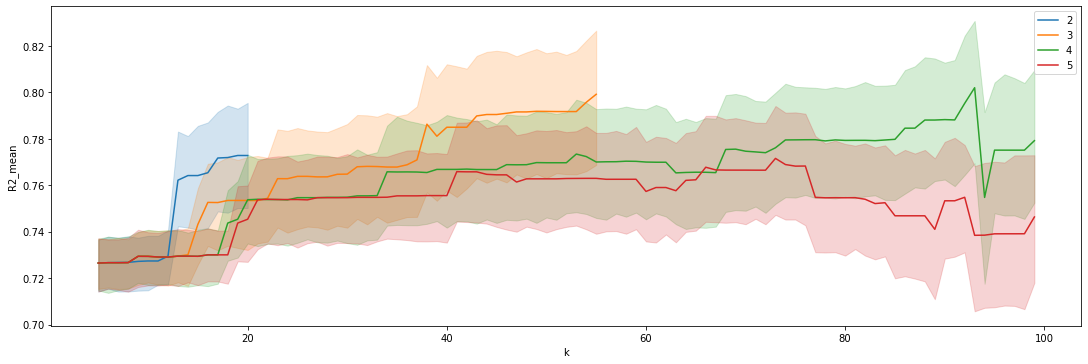

In [17]:
df_plt_res = pd.DataFrame(all_res)
df_plt_res = df_plt_res.loc[df_plt_res['R2_mean'] > 0]

df_plt_res.groupby(['d']).head(2).head(5)

ax = t.get_ax(0.33)
for d in df_plt_res['d'].unique():
    df_plt = df_plt_res.loc[df_plt_res['d'] == d]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)

## Best 2 models

In [168]:
cv = RepeatedKFold(n_splits=8, n_repeats=10)
models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.1, 0.2, 0.25] ],
]

metrics = [r2_score]

In [169]:
%%time

all_res = []
res_count = 0

for i_degree in range(3, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    # X_poly[X_poly.columns] = scale(X_poly, with_mean=False)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]))
    
    for k in range (50, min(X_poly.shape[1], 100)):
        for model in models_and_params:
            ss = SelectKBest(f_regression, k = k)
            X_poly_k = pd.DataFrame(data = ss.fit_transform(X_poly, y), columns = ss.get_feature_names_out(), index = X_poly.index)
            
            res = t.grid_exec(
                lambda model: m.cv_regression(model, cv, X_poly_k, y, metrics), 
                models_and_params, 
            )
            
            for r in res:                
                r['d'] = i_degree
                r['k'] = k
                
            all_res.extend(res)

            res_count += 1
            if res_count % 10 == 0:
                m.display_stats(
                    pd.DataFrame(all_res).groupby(['d', 'model']).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
                )

CPU times: user 4h 14min 18s, sys: 7h 23min 12s, total: 11h 37min 31s
Wall time: 58min 16s


,model,params,n_folds,R2_mean,R2_std,time,d,k
0,LinearRegression,,80,0.824362,0.088309,1.320757,3,50
1,Ridge,'alpha': 0.1,80,0.853717,0.010219,0.671938,3,50
96,LinearRegression,,80,0.808777,0.042862,1.525435,4,50
97,Ridge,'alpha': 0.1,80,0.821161,0.016137,0.898635,4,50
896,LinearRegression,,80,0.793658,0.075775,1.749895,5,50


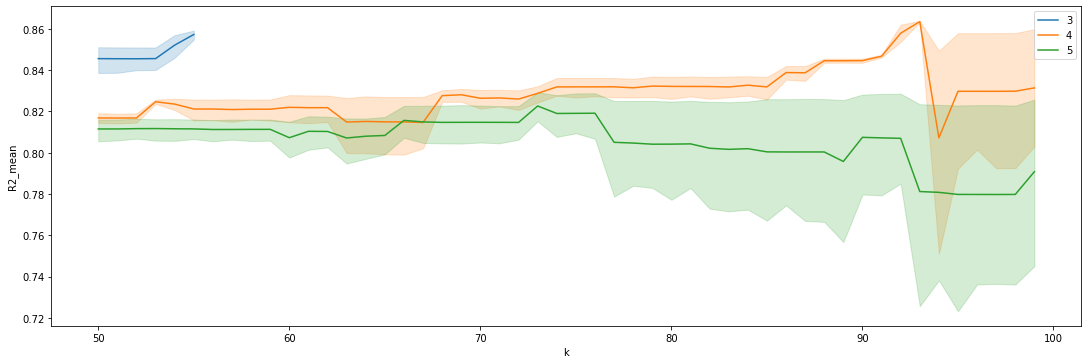

In [170]:
df_plt_res = pd.DataFrame(all_res)
df_plt_res = df_plt_res.loc[df_plt_res['R2_mean'] > 0]

df_plt_res.groupby(['d']).head(2).head(5)

ax = t.get_ax(0.33)
for d in df_plt_res['d'].unique():
    df_plt = df_plt_res.loc[df_plt_res['d'] == d]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)

## Further Tuning

In [171]:
cv = RepeatedKFold(n_splits=8, n_repeats=10)
models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.025, 0.05] ],
]

metrics = [r2_score]

In [172]:
%%time

all_res = []
res_count = 0

for i_degree in range(3, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    # X_poly[X_poly.columns] = scale(X_poly, with_mean=False)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]))
    
    for k in range (50, min(X_poly.shape[1], 200)):
        for model in models_and_params:
            ss = SelectKBest(f_regression, k = k)
            X_poly_k = pd.DataFrame(data = ss.fit_transform(X_poly, y), columns = ss.get_feature_names_out(), index = X_poly.index)
            
            res = t.grid_exec(
                lambda model: m.cv_regression(model, cv, X_poly_k, y, metrics), 
                models_and_params, 
            )
            
            for r in res:                
                r['d'] = i_degree
                r['k'] = k
                
            all_res.extend(res)

            res_count += 1
            if res_count % 10 == 0:
                m.display_stats(
                    pd.DataFrame(all_res).groupby(['d', 'model']).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
                )

CPU times: user 6h 56min 56s, sys: 11h 33min 42s, total: 18h 30min 39s
Wall time: 1h 32min 44s


,model,params,n_folds,R2_mean,R2_std,time,d,k
0,LinearRegression,,80,0.824362,0.088309,1.233983,3,50
1,Ridge,'alpha': 0.025,80,0.856444,0.010024,0.790235,3,50
54,LinearRegression,,80,0.808777,0.042862,1.887873,4,50
55,Ridge,'alpha': 0.025,80,0.823635,0.016543,1.101821,4,50
738,LinearRegression,,80,0.793658,0.075775,1.471627,5,50


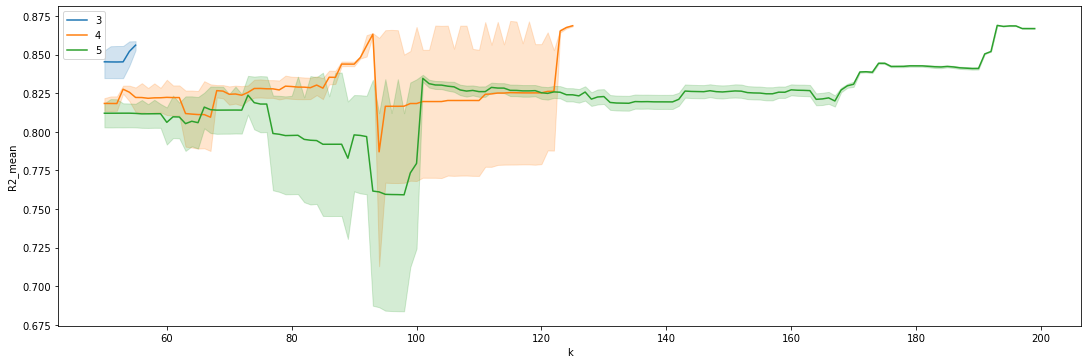

In [173]:
df_plt_res = pd.DataFrame(all_res)
df_plt_res = df_plt_res.loc[df_plt_res['R2_mean'] > 0]

df_plt_res.groupby(['d']).head(2).head(5)

ax = t.get_ax(0.33)
for d in df_plt_res['d'].unique():
    df_plt = df_plt_res.loc[df_plt_res['d'] == d]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)